In [2]:
#!conda install -c conda-forge basemap --yes
!conda install -c conda-forge basemap-data-hires --yes

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/nbuser/anaconda3_420:

The following NEW packages will be INSTALLED:

    basemap:            1.2.0-py35h50ae964_0   conda-forge
    basemap-data-hires: 1.2.0-0                conda-forge
    pyproj:             1.9.5.1-py35h508ed2a_5 conda-forge
    pyshp:              2.0.1-py_0             conda-forge
    readline:           7.0-ha6073c6_4                    

The following packages will be UPDATED:

    conda:              4.3.31-py35_0                      --> 4.5.11-py35_0        conda-forge
    pycosat:            0.6.1-py35_1                       --> 0.6.3-py35h470a237_1 conda-forge

The following packages will be SUPERSEDED by a higher-priority channel:

    conda-env:          2.6.0-h36134e3_1                   --> 2.6.0-1              conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.56 MB/s
readline-7.0-h 100% |##

In [1]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

ImportError: No module named 'mpl_toolkits.basemap'

In [2]:
from datetime import date
import csv
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize 
from math import ceil
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.path import Path

In [3]:
def plotNames (info,shape):
    xc, yc = zip(*shape)
    plt.text((max(xc)+min(xc))/2,(max(yc)+min(yc))/2,info['MD_NAME'],ha='center',va='center', zorder=5, fontsize=10)



Text(0,0.5,'tempmax [°C]')

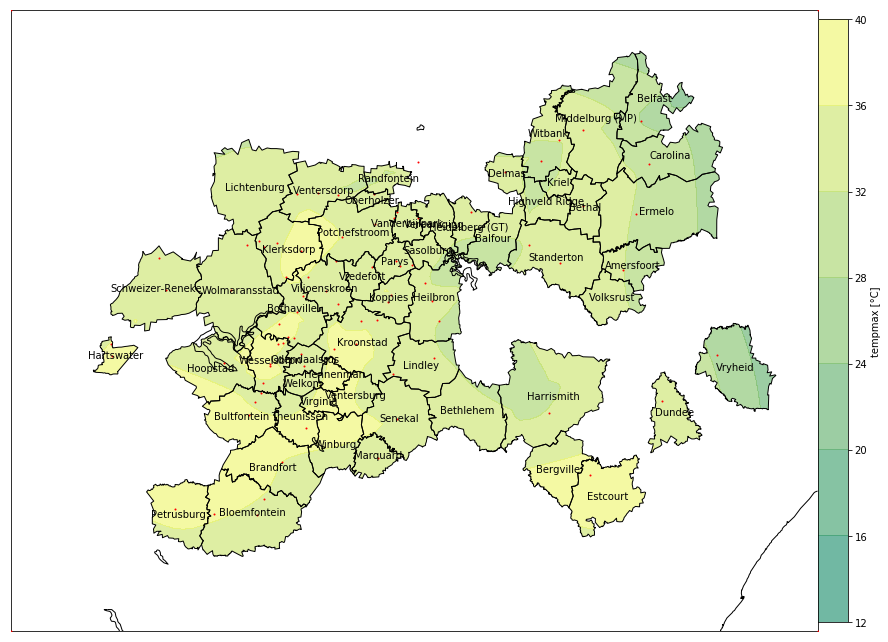

In [9]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)


df1 = pd.read_csv('data/temp20181030.csv', na_values=['NaN'], sep=',')
norm = Normalize()

measurement = 'tempmax'

extremes = [[-30.163374,23.785686,21.6],[-24.69508,23.785686,21.3],[-24.69508,31.79263,11.7],[-30.163374,31.79263,13.3]]

df2 = pd.DataFrame(extremes, columns=['lat','lon', measurement])
data = df1.append(df2)

#mapextent
lllon = data['lon'].min()
lllat = data['lat'].min()
urlon = data['lon'].max()
urlat = data['lat'].max()

#Generate Basemap
pad = 0  # padding around map extents
m = Basemap(
    projection = 'merc', \
    llcrnrlon = lllon - pad, \
    llcrnrlat = lllat - pad, \
    urcrnrlon = urlon + pad, \
    urcrnrlat = urlat + pad, \
    resolution='h', \
    ax=ax)

m.drawcoastlines(zorder = 3)
m.readshapefile('data/grense', 'grense',zorder=10,linewidth=1, drawbounds=True)

for info, shape in zip(m.grense_info, m.grense):
    plotNames(info,shape)


# transform lon / lat coordinates to map projection
data['projected_lon'], data['projected_lat'] = m(*(data.lon.values, data.lat.values))

#Plot station coordinates on map
m.scatter(data['projected_lon'], data['projected_lat'], marker = 'o', color='r', zorder=3, s=1)

#Interpolate weather data to meshgrid
x, y, z = data['projected_lon'].values, data['projected_lat'].values, data[measurement].values
xi = np.arange(0, max(x), abs((abs(max(x))-abs(min(x))))/len(x))
yi = np.arange(0, max(y), abs((abs(max(y))-abs(min(y))))/len(y))
xi,yi = np.meshgrid(xi,yi)

zi = griddata((x,y),z,(xi,yi),method='cubic')

cs = m.contourf(xi, yi, zi, zorder=1, alpha=0.6, cmap='summer')
#plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=12, colors='k')

##limits of the map:
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

#
polys = [map_edges] + m.grense

codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)

#Important - Set Zorder greater than Contour and less than Map borders
patch = PathPatch(path,facecolor='white', lw=0, zorder =2)

##masking the data:
ax.add_patch(patch)

#Contour legend
#proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

#plt.legend(proxy, ["range(2-3)", "range(3-4)", "range(4-6)"])

cbar = plt.colorbar(cs, fraction=0.036, pad=0)
cbar.ax.set_ylabel(measurement +' [\N{DEGREE SIGN}C]')
# Add the contour line levels to the colorbar

#today = str(date.today())
#Save plot as image
#plt.savefig(today+'-'+measurement)